In [3]:
from googleapiclient.discovery import build
from dateutil import parser
import pandas as pd
from IPython.display import JSON

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

api_key = #'Insert put api key here'
channel_ids = [#'Insert channel id/ids here'
        ]
playlist_ids=[#'Insert playlist id/ids here'
             ]
             
api_service_name = "youtube"
api_version = "v3"

#Gets credentials and create an API client
youtube = build(
    api_service_name, api_version, developerKey=api_key)

def get_channel_stats(youtube, channel_ids):
        
    all_data = []
    
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(channel_ids)
    )
    response = request.execute()

    for item in response['items']:
        data = {'channelName': item['snippet']['title'],
                'subscribers': item['statistics']['subscriberCount'],
                'views': item['statistics']['viewCount'],
                'totalVideos': item['statistics']['videoCount'],
                'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
        }
        
        all_data.append(data)
        
    return pd.DataFrame(all_data)

channel_info = get_channel_stats (youtube,channel_ids)

channel_info
def get_video_ids(youtube, playlist_ids):
    video_ids = []
    
    for playlist in playlist_ids:
        
        request = youtube.playlistItems().list(
            part="snippet,contentDetails",
            playlistId=playlist,
            maxResults = 50)
        response = request.execute()
        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])
            
        next_page_token = response.get('nextPageToken')
        while next_page_token is not None:
            request = youtube.playlistItems().list(
                part="snippet,contentDetails",
                playlistId=playlist,
                maxResults = 50,
                pageToken = next_page_token)
            response = request.execute()
            
            for item in response['items']:
                video_ids.append(item['contentDetails']['videoId'])
        
                next_page_token = response.get('nextPageToken')
    return video_ids

video_ids=get_video_ids(youtube,playlist_ids)

def get_video_details(youtube, video_ids):

    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
    
    return pd.DataFrame(all_video_info)

video_info= get_video_details(youtube, video_ids)

#Checks for NULL values,
video_info.isnull().any()

# Converts count columns to numeric
numeric_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_info[numeric_cols] = video_info[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

#Publish day in the week
video_info['publishedAt'] = video_info['publishedAt'].apply(lambda x: parser.parse(x)) 
video_info['dayPublished'] = video_info['publishedAt'].apply(lambda x: x.strftime("%A")) 

#Converts duration to seconds
import isodate
video_info['durationSecs'] = video_info['duration'].apply(lambda x: isodate.parse_duration(x))
video_info['durationSecs'] = video_info['durationSecs'].astype('timedelta64[s]')

video_info[['durationSecs', 'duration']] 

#Adds tag count
video_info['tagCount'] = video_info['tags'].apply(lambda x: 0 if x is None else len(x))
video_info

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,dayPublished,durationSecs,tagCount
0,rf1UB1JTDik,Trash Taste,What Anime Conventions DON'T Tell You | Trash ...,🖥️Get an extra 3 months free at https://www.ex...,"[TrashTaste, Trash, Trash Taste, Taste, Trash ...",2023-07-14 20:00:15+00:00,523155.0,17522.0,NaN,940.0,PT1H55M17S,hd,false,Friday,0 days 01:55:17,14
1,aTP4X03HWc4,Trash Taste,We Don't Know How To Make Friends... | Trash T...,🍯 Get PayPal Honey for FREE at https://www.joi...,"[TrashTaste, Trash, Trash Taste, Taste, Trash ...",2023-07-07 20:00:01+00:00,662164.0,24591.0,NaN,1974.0,PT2H18S,hd,false,Friday,0 days 02:00:18,14
2,k7AJ5Axj4Bc,Trash Taste,We Became Americans for a Day and FAILED | Tra...,🥤Buy Waifu Cups at https://gamersupps.gg/Trash...,"[TrashTaste, Trash, Trash Taste, Taste, Trash ...",2023-07-04 20:00:11+00:00,844526.0,60807.0,NaN,3347.0,PT33M15S,hd,false,Tuesday,0 days 00:33:15,14
3,9pjD4zdPtF0,Trash Taste,TRASH TASTE AT AX #trashtaste #podcast #animee...,,None,2023-07-01 04:09:53+00:00,170794.0,14373.0,NaN,137.0,PT23S,hd,false,Saturday,0 days 00:00:23,0
4,1CjQlv66S1Q,Trash Taste,The Most INSANE Australians (ft. @coldones) | ...,👟Check out Vessi styles at https://www.vessi.c...,"[TrashTaste, Trash, Trash Taste, Taste, Trash ...",2023-06-30 20:00:00+00:00,754135.0,29250.0,NaN,1439.0,PT2H3M40S,hd,false,Friday,0 days 02:03:40,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2113,cwoz-3upogQ,The Anime Man,"""Two Sugars"" (Little Busters OST Piano Cover)","For anime reviews, lists and discussions visit...","[Little, Soundtrack, Piano, little busters!, k...",2013-07-20 04:04:17+00:00,17375.0,837.0,NaN,69.0,PT1M21S,hd,false,Saturday,0 days 00:01:21,16
2114,arKeNL7b4TU,The Anime Man,"""Saibou Kioku"" by nano.RIPE (acoustic cover)","For anime reviews, lists and discussions visit...","[Acoustic Music (Musical Genre), Cover Band (M...",2013-07-17 13:19:00+00:00,31797.0,1763.0,NaN,245.0,PT4M27S,hd,false,Wednesday,0 days 00:04:27,18
2115,iGZtMjfxU2E,The Anime Man,Summer 2013 Anime Season: First Impressions,"For anime reviews, lists and discussions visit...","[Season (Quotation Subject), First, Summer, Ep...",2013-07-17 04:58:44+00:00,15258.0,514.0,NaN,51.0,PT3M1S,hd,false,Wednesday,0 days 00:03:01,25
2116,Dq5dq83LilU,The Anime Man,Spring 2013 Anime Season: Overall Thoughts,"For anime reviews, lists and discussions visit...","[spring, anime, season, review, overall, thoug...",2013-07-04 07:03:52+00:00,25266.0,963.0,NaN,136.0,PT5M50S,hd,false,Thursday,0 days 00:05:50,20


<Axes: xlabel='viewCount', ylabel='likeCount'>

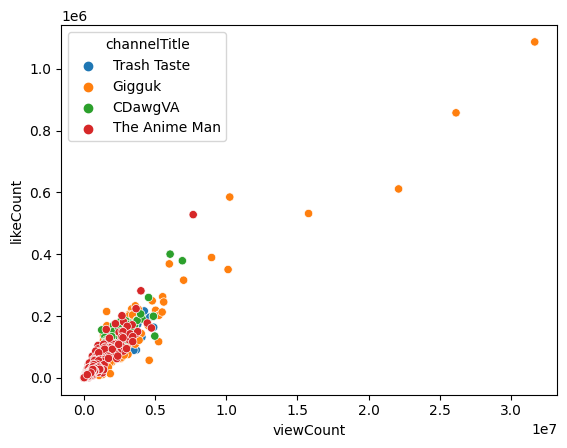

In [46]:
sns.scatterplot(data=video_info, x="viewCount", y="likeCount", hue="channelTitle")

<Axes: xlabel='publishedAt', ylabel='likeCount'>

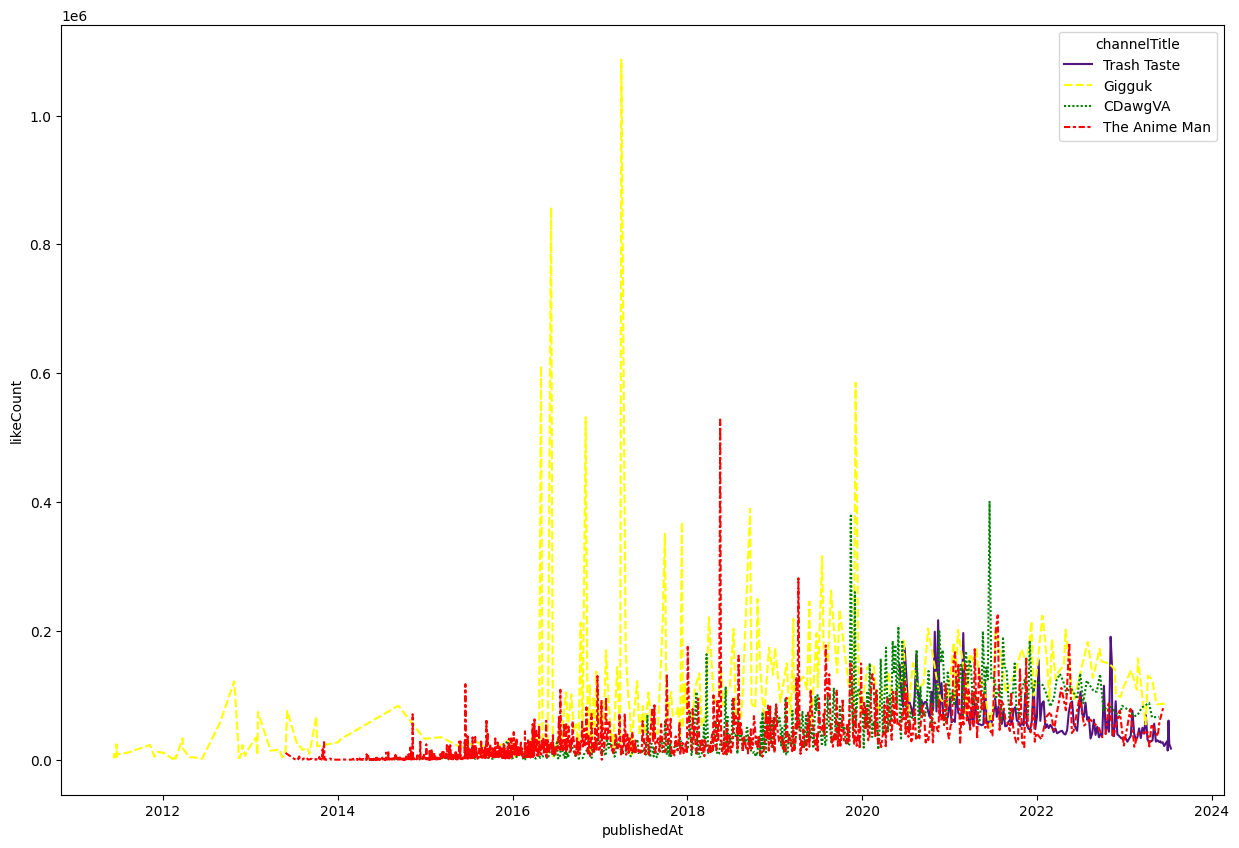

In [59]:
flatui = ["#541480", "yellow", "green",'red']
sns.set_palette(flatui)
plt.figure(figsize=(15,10))
sns.lineplot(data=video_info, x='publishedAt', y='likeCount', hue='channelTitle', style='channelTitle',)

<Axes: xlabel='publishedAt', ylabel='viewCount'>

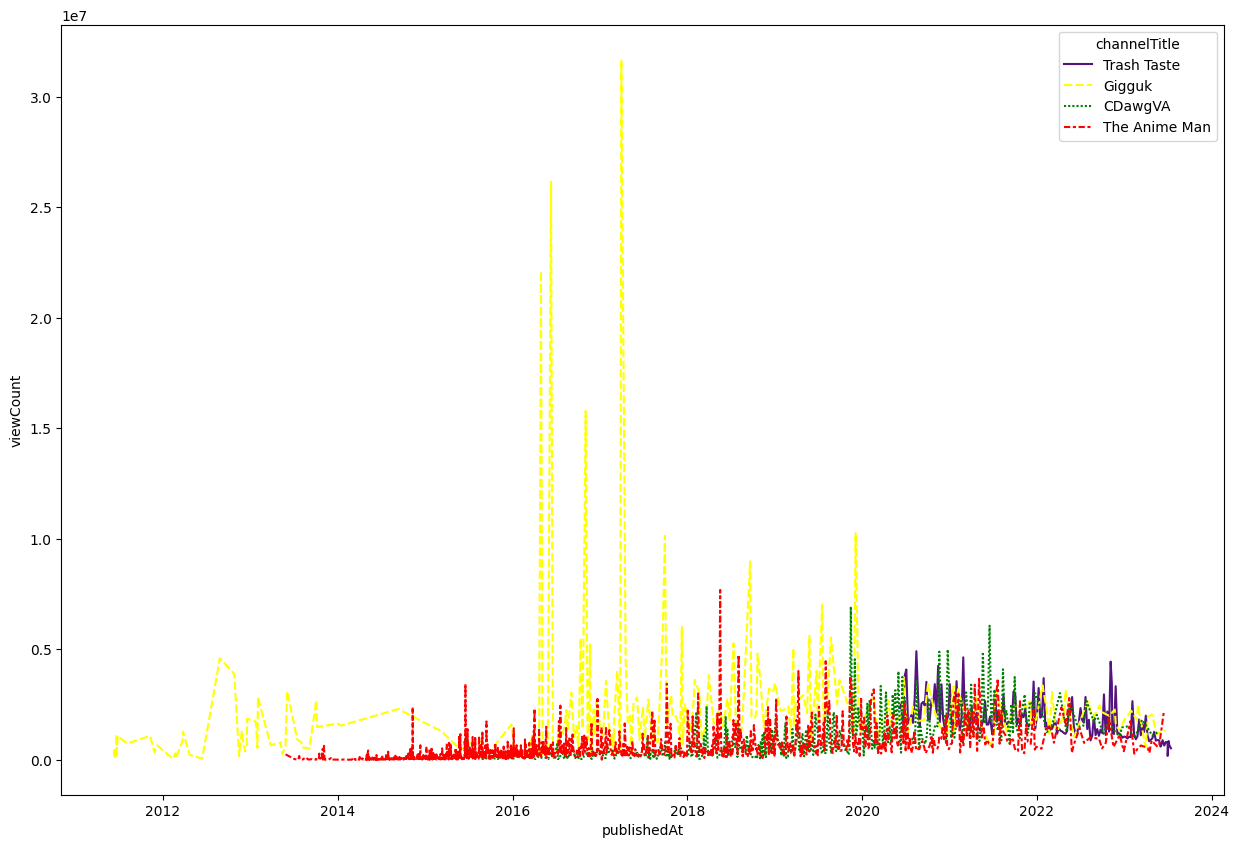

In [60]:
flatui = ["#541480", "yellow", "green",'red']
sns.set_palette(flatui)
plt.figure(figsize=(15,10))
sns.lineplot(data=video_info, x='publishedAt', y='viewCount', hue='channelTitle', style='channelTitle',)

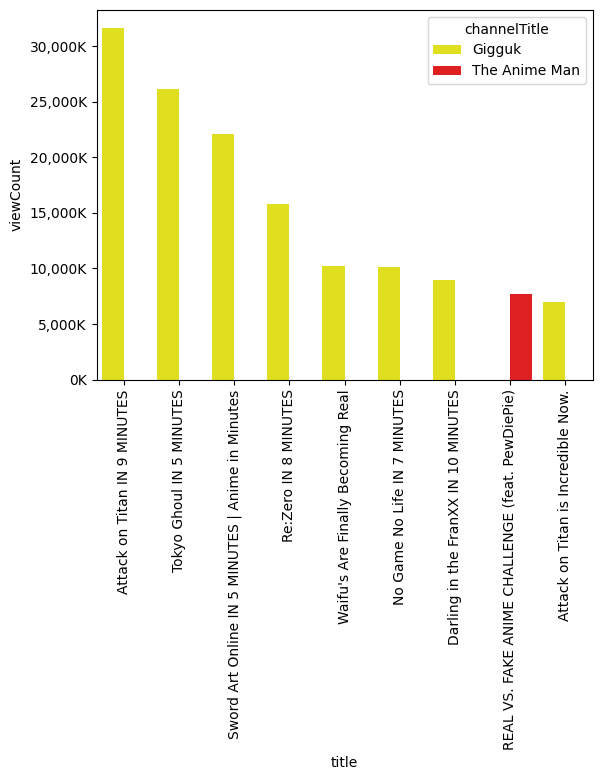

In [61]:
flatui = ["yellow",'red']
sns.set_palette(flatui)
ax = sns.barplot(x = 'title', y = 'viewCount', hue='channelTitle', data = video_info.sort_values('viewCount', ascending=False)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

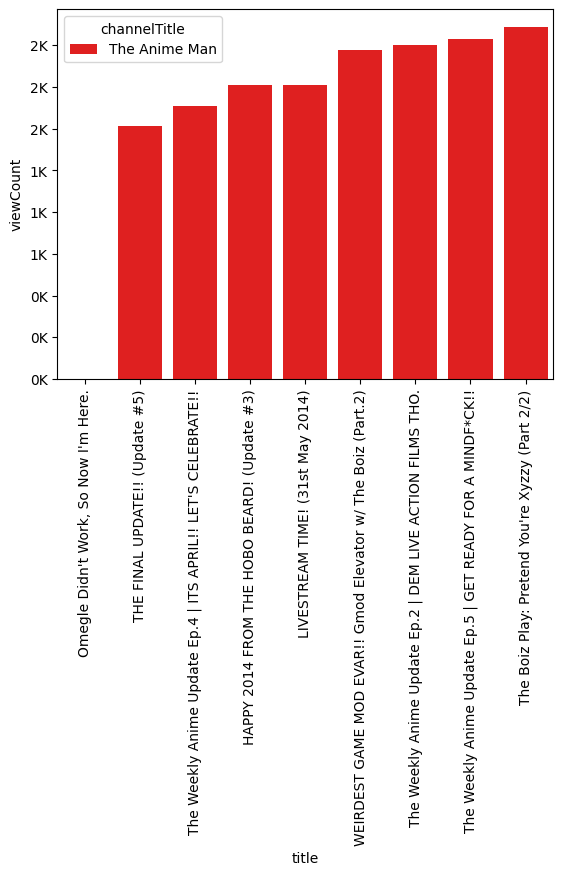

In [64]:
flatui = ['red']
sns.set_palette(flatui)
ax = sns.barplot(x = 'title', y = 'viewCount', hue='channelTitle',, data = video_info.sort_values('viewCount', ascending=True)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

<Axes: xlabel='dayPublished', ylabel='Count'>

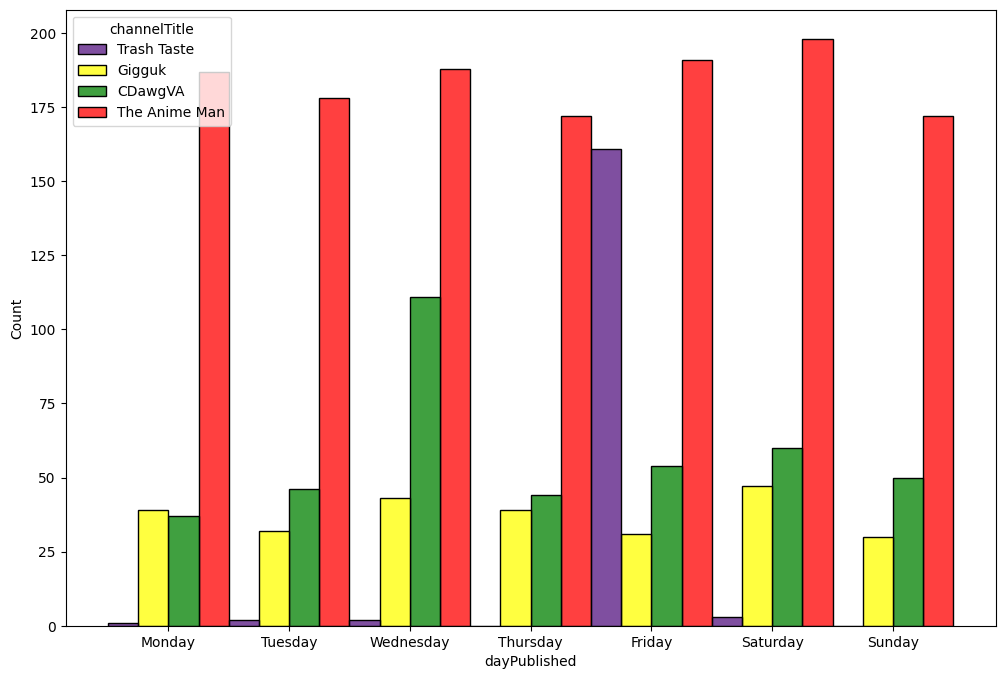

In [120]:
flatui = ["#541480", "yellow", "green",'red']
sns.set_palette(flatui)
plt.figure(figsize=(12,8))
video_info['dayPublished'] = pd.Categorical(video_info['dayPublished'], ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
sns.histplot(data=video_info, x='dayPublished',hue="channelTitle", multiple="dodge", )

<Axes: xlabel='dayPublished', ylabel='viewCount'>

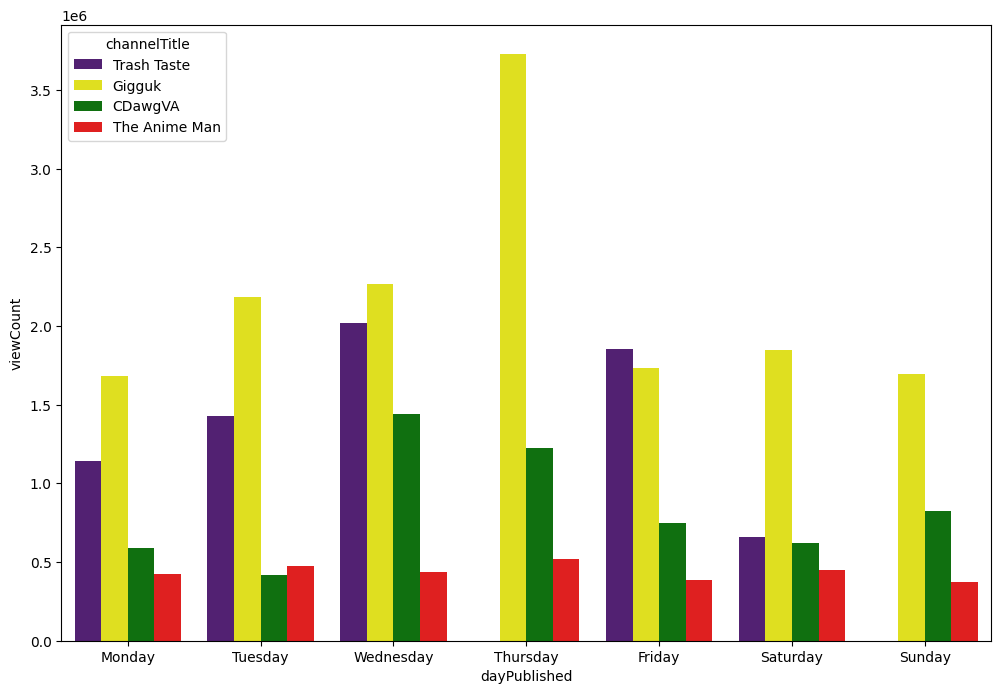

In [10]:
flatui = ["#541480", "yellow", "green",'red']
sns.set_palette(flatui)
plt.figure(figsize=(12,8))
video_info['dayPublished'] = pd.Categorical(video_info['dayPublished'], ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
sns.barplot(x ='dayPublished', y ='viewCount', hue='channelTitle', data = video_info, errorbar=('ci', 0))

<Axes: xlabel='publishedAt', ylabel='viewCount'>

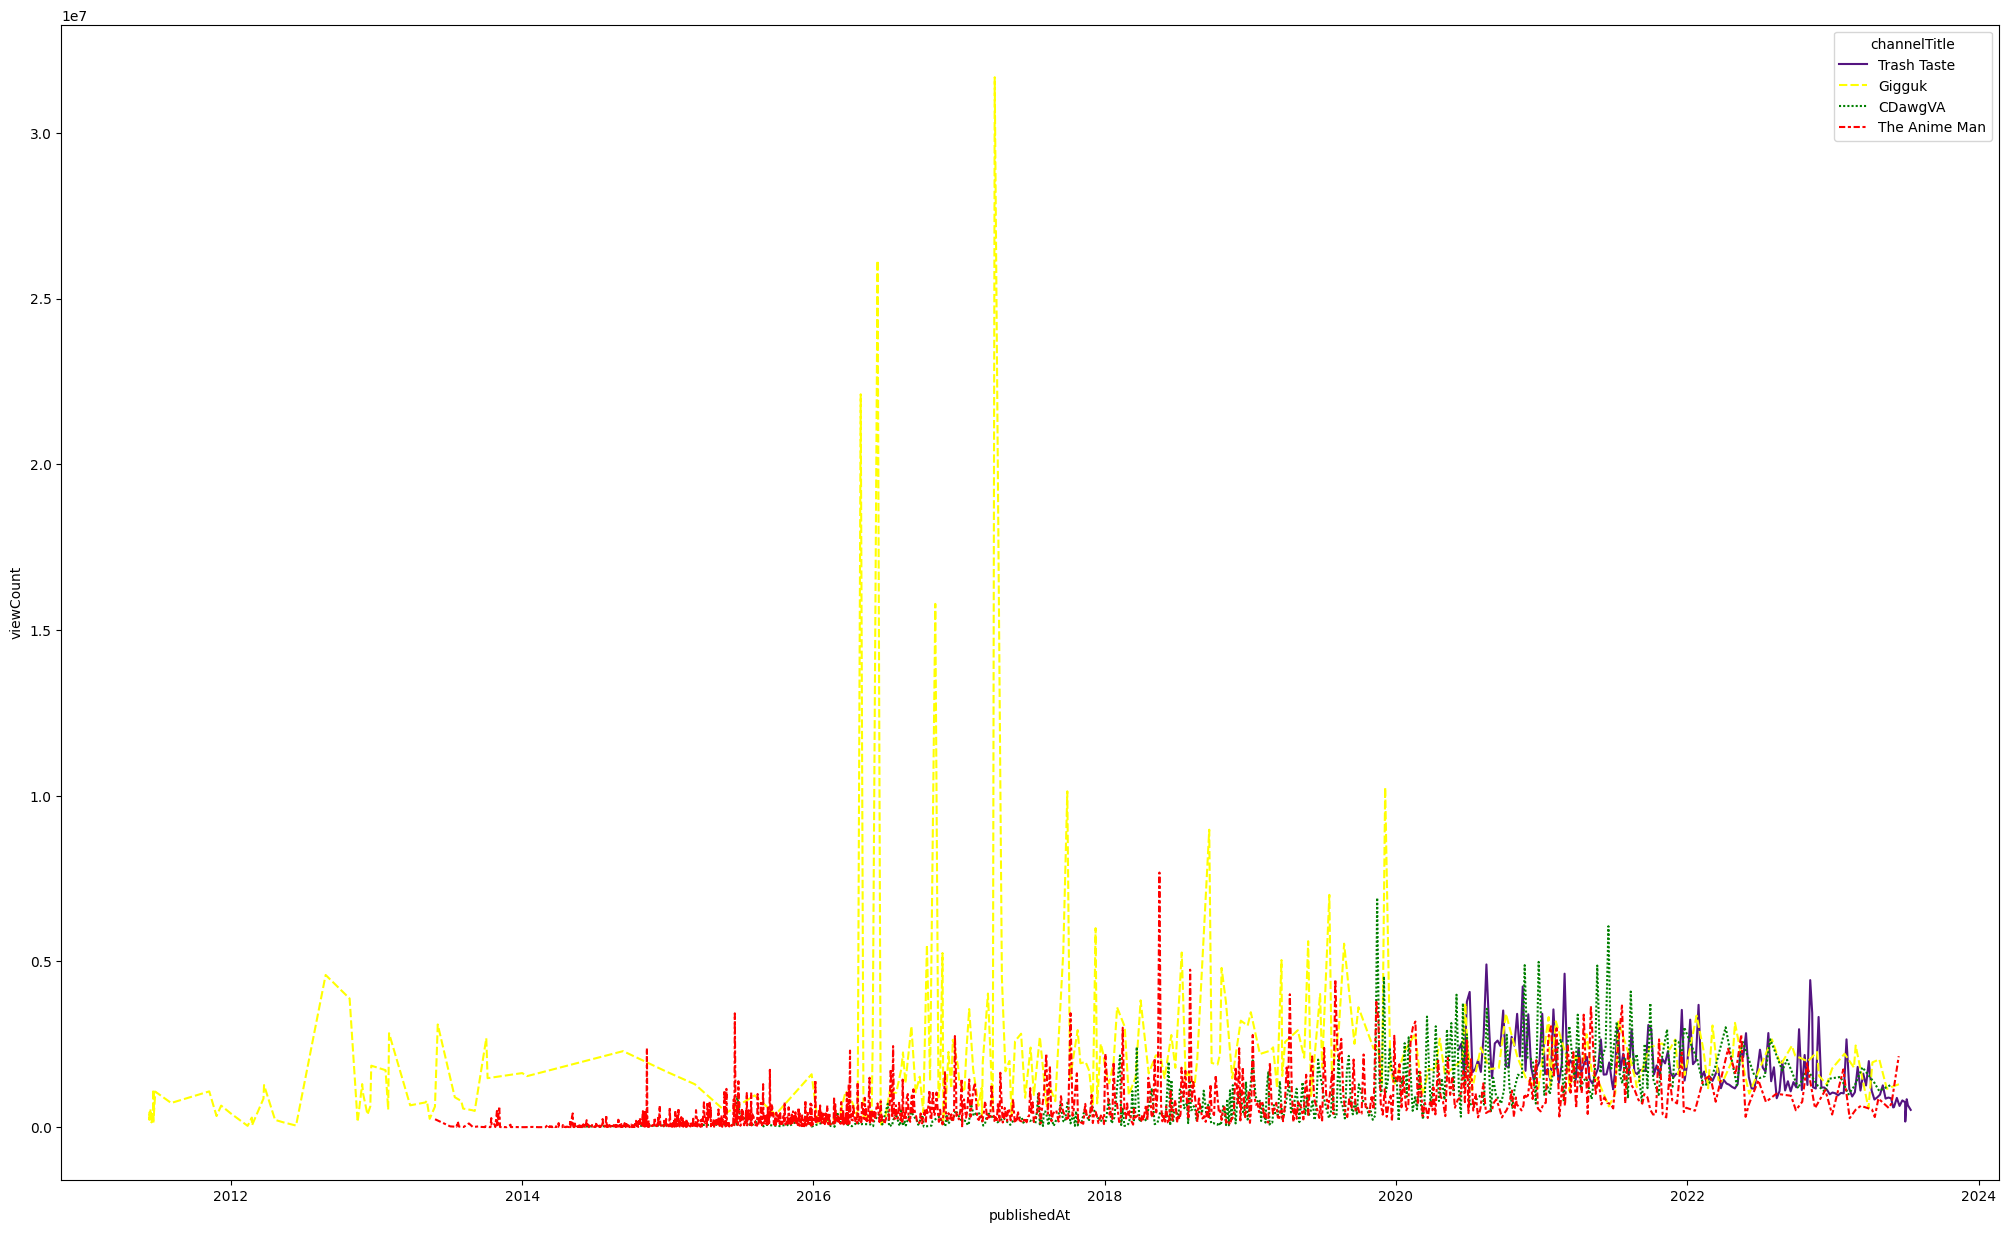

In [16]:
flatui = ["#541480", "yellow", "green",'red']
sns.set_palette(flatui)
plt.figure(figsize=(25,15))
sns.lineplot(data=video_info, x='publishedAt', y='viewCount', hue='channelTitle', style='channelTitle',)